### ANALYSIS OF MOVIE REVIEW From IMDB
##### USING  Classical Machine Learning Models and Ensemble of Classical Machine Learning Models 

<h3> 
     Author: Sushma G.
</h3>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


from pandas import ExcelWriter
from math import sqrt
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
plt.style.use('bmh')


## Setting plotting configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
#plt.style.context('seaborn-talk')
plt.style.use(['tableau-colorblind10'])
#plt.style.use('fivethirtyeight')
params = {'legend.fontsize': '16',
          'figure.figsize': (15, 5),
         'axes.labelsize': '20',
         'axes.titlesize':'30',
         'xtick.labelsize':'18',
         'ytick.labelsize':'18'}
plt.rcParams.update(params)

plt.rcParams['text.color'] = '#A04000'
plt.rcParams['xtick.color'] = '#283747'
plt.rcParams['ytick.color'] = '#808000'
plt.rcParams['axes.labelcolor'] = '#283747'

## Task1: Load Data

In [3]:
raw_reviews_df = pd.read_csv("imdb_reviews.csv") #read from csv file

In [4]:
raw_reviews_df.shape #view dimensions of the pandas daframe

(50000, 2)

In [5]:
raw_reviews_df.iloc[0:1] #view one movie review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive


In [6]:
raw_reviews_df.info() #vew information abot Daframe in general

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Task2: Preprocess Data

In this task, data preprocessing tasks such as adjust class imbalances , filling out missing values are done. This is done to prevent bias later for Classification Task

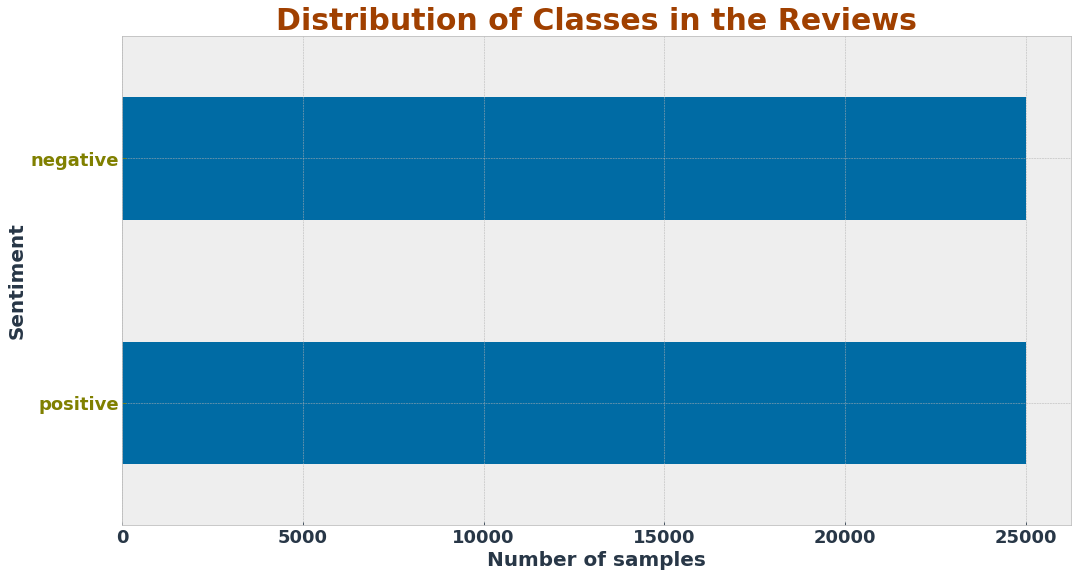

In [13]:
plt.figure(figsize = (17,9))
raw_reviews_df["sentiment"].value_counts().plot(kind = 'barh')
plt.title("Distribution of Classes in the Reviews")
plt.ylabel("Sentiment")
plt.xlabel("Number of samples")
plt.show();

In [14]:
print("Total Samples for Positive Sentiments: ",len(raw_reviews_df[raw_reviews_df["sentiment"]=="positive"]))
print("Total Samples for Negative Sentiments: ",len(raw_reviews_df[raw_reviews_df["sentiment"]=="negative"]))

Total Samples for Positive Sentiments:  25000
Total Samples for Negative Sentiments:  25000


Looks like the classes(sentiments) are balanced perfectly. SO need for sampling. Now check if there are any missing values in review column.

In [15]:
print("Total Samples which do not have reviews: ",len(raw_reviews_df[raw_reviews_df["review"]==None]))

Total Samples which do not have reviews:  0


Awesome, no missing reviews so not need for data imputation. Now lets view frequenly used words in reviews in a word cloud

In [17]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud #library that allows word cloud to be generated

def generate_word_cloud(dataframe_df,column_name,img_file=None,background_color="black",max_words=2000):
    """ This function generates word cloud
    
    Args:
        dataframe: the datafram object which contains column whose word cloud is to be generated
        column_name: the name of the column in dataframw whose cloud is to be generated
        
    Returns:
        None
    """
    #convert the column specified by column_name in dataset_df(dataframe) to list
    sentences_list = dataframe_df[column_name].tolist()
    
    #convert a list to sentence
    #sentences_single_string = " ".join(sentences_list)
    sentences_single_string = " ".join(map(str,sentences_list))
    
    #plot word cloud
    plt.figure(figsize=(15,15))
    
    img_mask = None
    
    if img_file != None:
        img_mask = np.array(Image.open(img_file))

    wc = WordCloud(mask=img_mask,
                   max_words=max_words,
                   background_color=background_color)        
        
    plt.imshow(wc.generate(sentences_single_string),interpolation="bilinear")
    plt.title("Word Cloud For " +  column_name)
    plt.show()

Lets Plot word cloud for all the reviews

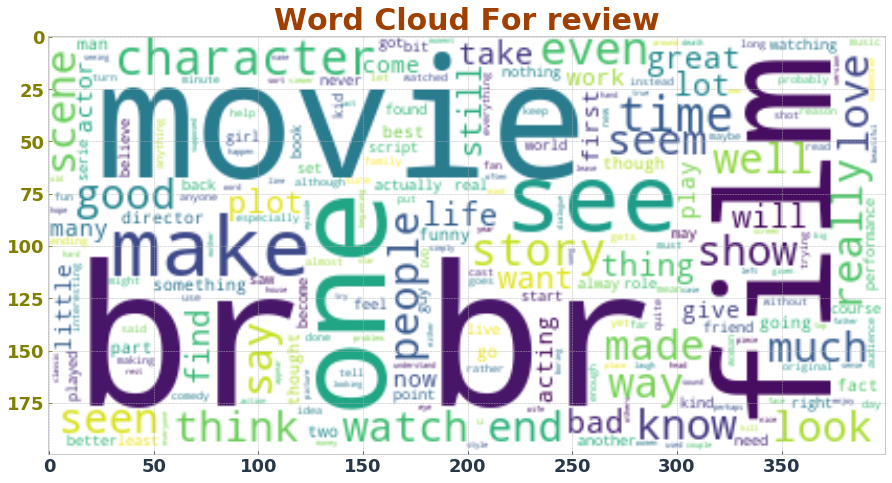

Total Time Taken: 62820.15109062195 ms


In [18]:
import time
tic= time.time()
generate_word_cloud(raw_reviews_df,"review",background_color="white")
toc = time.time()
diff = 1000*(toc - tic)
print("Total Time Taken: " + str(diff) + " ms")

### Task 3: Text Preprocessing

In [19]:
#import required libraries
from nltk.corpus import stopwords #for stopwords
from nltk.stem import PorterStemmer #for word stemming
from nltk.tokenize import TweetTokenizer #for toekinizing string to list of words
import string #for punctuation
import re #for regular expression
import numpy as np

In [20]:
def process_string(text):
    """This function returns a processed list of words from the given text
    
    This function removes html elements and urls using regular expression, then
    converts string to list of workds, them find the stem of words in the list of words and
    finally removes stopwords and punctuation marks from list of words.
    
    Args:
        text(string): The text from which hrml elements, urls, stopwords, punctuation are removed and stemmed
        
    Returns:
        clean_text(string): A text formed after text preprocessing.
    """
    
    #remove any urls from the text
    text = re.sub(r"https:\/\/.*[\r\n]*","",text)
    
    #remove any urls starting from www. in the text
    text = re.sub(r"www\.\w*\.\w\w\w","",text)
    
    #remove any html elements from the text
    text = re.sub(r"<[\w]*[\s]*/>","",text)
    
    #remove prediods  marks
    text = re.sub(r"[\.]*","",text)
    
    #initilze tweet tokenizer 
    tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
    
    #tokenize text
    text_tokens = tokenizer.tokenize(text)
    
    #intizlize porter stemmer
    porter_stemmer = PorterStemmer()
    
    #get english stopwords
    english_stopwords = stopwords.words("english")
    
    cleaned_text_tokens = [] # a list to hold cleaned text tokens
    
    for word in text_tokens:
        if((word not in english_stopwords) and #remove stopwords
            (word not in string.punctuation)): #remove punctuation marks
                
                stemmed_word = porter_stemmer.stem(word) #get stem of the current word
                cleaned_text_tokens.append(stemmed_word) #appened stemmed word to list of cleaned list
    
    #combine list into single string
    clean_text = " ".join(cleaned_text_tokens)
    
    return clean_text

In [21]:
raw_reviews_df["review"].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [22]:
process_string(raw_reviews_df["review"].iloc[0])

"one review mention watch 1 oz episod hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard who'll sold nickel inmat who'll kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort viewingtha

<p> <h5> clearly this cleaned review is free of html tags as well now. Lets apply this new text cleaning method to all 50k reviews </h5> </p>

In [23]:
raw_reviews_df["review"] = raw_reviews_df["review"].apply(process_string)

In [24]:
#save processed reviews for future use
#save file to csv
raw_reviews_df.to_csv("imdb_reviews_cleaned.csv")

In [25]:
raw_reviews_df = pd.read_csv("imdb_reviews_cleaned.csv")

In [26]:
raw_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50000 non-null  int64 
 1   review      50000 non-null  object
 2   sentiment   50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [27]:
raw_reviews_df["review"].iloc[0]

"one review mention watch 1 oz episod hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard who'll sold nickel inmat who'll kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort viewingtha

<p> <h5>
Lets look at reviews after they have been cleaned
</h5> </p>

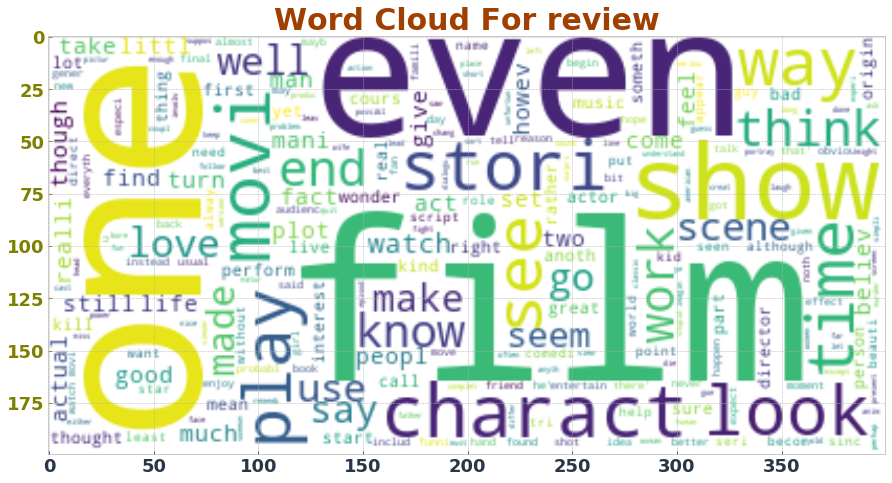

Total Time Taken: 45.772804737091064 ms


In [28]:
tic = time.time()
generate_word_cloud(raw_reviews_df,"review",background_color="white")
toc = time.time()
diff = toc - tic
print("Total Time Taken: " + str(diff) + " ms")

<p> <h5> 
Clearly the new text preprocessing method resulted in much more cleaner reviews, the prominent "br" tag that has massive occurence is not visible anymore. Thanks to regular epression. Lets further examine these word could by looking into positive only and negative only reviews </h5> </p>

<p> <h5> The review have been saved and loaded.</h5> </p>

### Task 4: Split Data into Train and Test Set

<p> <h5>
The data set has to split into train(80%)/valid(10%)/test(10%) set. Train set will be used to train machine learning models and validation set will be used to tune the machine learning models and the test will be used to evaluate the performance of ml models. <br> <br>
There are two classes ("positive" and "negative") in the dataset. A blanced dataset containing equal number of samples from both classes.
</h5> </p>

In [29]:
#scikit learn library that splits data
from sklearn.model_selection import train_test_split

In [30]:
#first spli data into train and test set
review_train, review_test, labels_train, labels_test = train_test_split(raw_reviews_df["review"], raw_reviews_df["sentiment"], test_size=0.1, random_state=0)

In [31]:
#second split train set into train and valid set
review_train, review_valid, labels_train, labels_valid = train_test_split(review_train, labels_train, test_size=0.1111, random_state=0)

In [32]:
#see the sample count in all sets
print("Train Set: ")
print("Positive Samples count: " + str(len(review_train[labels_train=="positive"] )  ) )
print("Negative Samples count: " + str(len(review_train[labels_train=="negative"] )  ) )
print("Total Samples count: " + str(len(review_train)  ) )

Train Set: 
Positive Samples count: 20059
Negative Samples count: 19941
Total Samples count: 40000


In [33]:
#see the sample count in all sets
print("Valid Set: ")
print("Positive Samples count: " + str(len(review_valid[labels_valid=="positive"] )  ) )
print("Negative Samples count: " + str(len(review_valid[labels_valid=="negative"] )  ) )
print("Total Samples count: " + str(len(review_valid)  ) )

Valid Set: 
Positive Samples count: 2494
Negative Samples count: 2506
Total Samples count: 5000


In [34]:
#see the sample count in all sets
print("Test Set: ")
print("Positive Samples count: " + str(len(review_test[labels_test =="positive"] )  ) )
print("Negative Samples count: " + str(len(review_test[labels_test =="negative"] )  ) )
print("Total Samples count: " + str(len(review_test) ))

Test Set: 
Positive Samples count: 2447
Negative Samples count: 2553
Total Samples count: 5000


In [35]:
#convert train matrix from numpy matrix to pandas
review_train_df = pd.DataFrame()
review_train_df["review"] = review_train
review_train_df["sentiment"] = labels_train
review_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 13902 to 2487
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB


In [36]:
#convert valid matrix from numpy matrix to pandas
review_valid_df = pd.DataFrame()
review_valid_df["review"] = review_valid
review_valid_df["sentiment"] = labels_valid
review_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 24777 to 20223
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [37]:
#convert test matrix from numpy matrix to pandas
review_test_df = pd.DataFrame()
review_test_df["review"] = review_test
review_test_df["sentiment"] = labels_test
review_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 24777 to 20223
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [38]:
#make sure the reviews are in string format
review_train_df["review"] = review_train_df["review"].apply(lambda row_text: str(row_text))
review_valid_df["review"] = review_valid_df["review"].apply(lambda row_text: str(row_text))
review_test_df["review"] = review_test_df["review"].apply(lambda row_text: str(row_text))

### Task 5: Generate Features from reviews And Numerical labels for Sentiment

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
vectorizer = CountVectorizer() #instantiate vectorizer

In [41]:
feature_matrix_train = vectorizer.fit_transform(review_train_df["review"].tolist())

In [42]:
feature_matrix_train.shape

(40000, 118482)

In [43]:
feature_matrix_valid = vectorizer.transform(review_valid_df["review"].tolist())

In [44]:
feature_matrix_valid.shape

(5000, 118482)

In [45]:
feature_matrix_test = vectorizer.transform(review_test_df["review"].tolist())

In [46]:
feature_matrix_test.shape

(5000, 118482)

<p> <h5>
The sentiment for each review is labelled as positive or negative. Machine Learning Models require Numberical values so lets convert these labels to numerical labels
</h5> </p>

In [47]:
#import label encoder
from sklearn import preprocessing #library that alllows label encoding
label_encoder = preprocessing.LabelEncoder() #instantiate label encoder

In [48]:
label_matrix_train = label_encoder.fit_transform(review_train_df["sentiment"]) #encoded

In [49]:
label_matrix_train.shape

(40000,)

In [50]:
label_matrix_valid = label_encoder.fit_transform(review_valid_df["sentiment"]) #encoded

In [51]:
label_matrix_valid.shape

(5000,)

In [52]:
label_matrix_test = label_encoder.fit_transform(review_test_df["sentiment"]) #encoded

In [53]:
label_matrix_test.shape

(5000,)

<p><h5> 
Term-Doument Matrix is a poular matrix design in NLP. Lets create a term document matrix
</h5></p>

In [54]:
dt_train_df = pd.DataFrame.sparse.from_spmatrix(data = feature_matrix_train, columns = vectorizer.get_feature_names())
dt_valid_df = pd.DataFrame.sparse.from_spmatrix(data = feature_matrix_valid, columns = vectorizer.get_feature_names())
dt_test_df = pd.DataFrame.sparse.from_spmatrix(data = feature_matrix_test, columns = vectorizer.get_feature_names())

<p> <h5> The plot above shows frequnecy some top words used in the reviews. Now lets crea pipeline to do this task </h5> </p>

In [55]:
from matplotlib import pyplot as plt
import time

def plot_top_words(document_term_df,upper_threshold=10000,lower_threshold=10,count=20):
    
    #for time purposes
    tic = time.time()
    
    top_word_freq = {}
    #build frequency dictionary
    for col in document_term_df.columns:
        
        col_count = document_term_df[col].to_numpy().max()
        
        if lower_threshold < col_count < upper_threshold:
            top_word_freq[col] = col_count
            
        if len(top_word_freq) > count:
            break

    #print thresholds
    print("Upper Limit: " + str(upper_threshold))
    print("Lower Limit: " + str(lower_threshold))
    print("Requested Count: " + str(count))
    
    plt.figure(figsize=(20,10))
    
    y_vals = [top_word_freq[word] for word in top_word_freq.keys()]
    
    anotates = list(top_word_freq.keys())
    
    x_vals = [i for i in range(0,len(y_vals))]
    
    plt.scatter(x_vals,y_vals)

    plt.title("Top Word Counts")
    plt.xlabel("Top Words")
    plt.ylabel("Word Frequency")
    
    for y,a,x in zip(y_vals,anotates,x_vals):
        plt.annotate(a, #anotate
                     (x,y), #for this data point 
                    textcoords="offset points", #how to position text
                    xytext=(0,10), #distance from text to points (x,y)
                    ha="center") #horizontal alignment can beleft, right or center 
    
    #for time purposes
    toc = time.time()
    tictoc = (toc-tic)*1000
    print("Time Taken: " + str(tictoc) + " ms")

<p> <h5> Lets Look at the top words used in trainning set </h5> </p>

Upper Limit: 10000
Lower Limit: 20
Requested Count: 20
Time Taken: 4722.955942153931 ms


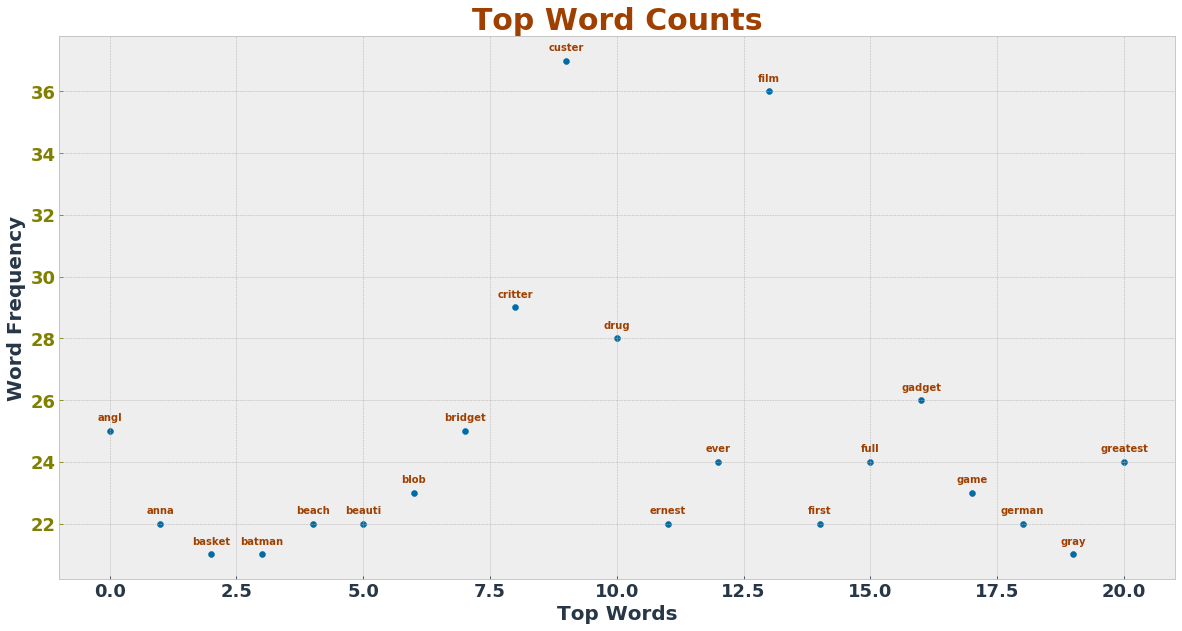

In [56]:
plot_top_words(dt_train_df,upper_threshold=10000,lower_threshold=20,count=20)

<p> <h5> Lets Look at the top words used in trainning set whose sentiment is labelled as negative </h5> </p>

Upper Limit: 10000
Lower Limit: 10
Requested Count: 30
Time Taken: 1012.2153759002686 ms


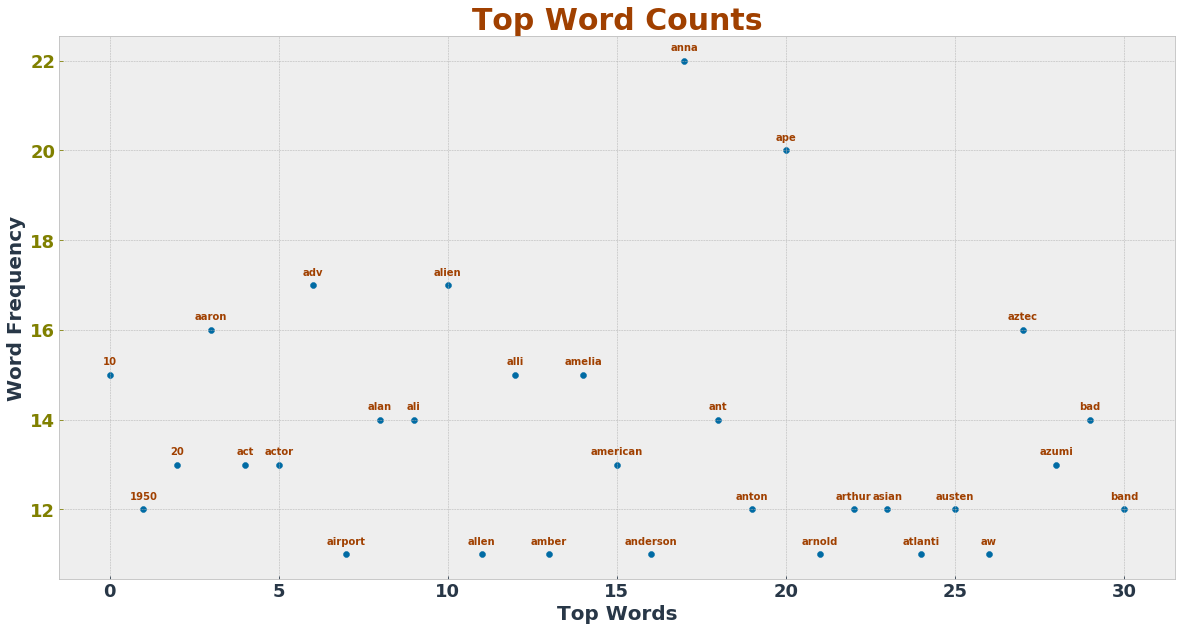

In [57]:
plot_top_words(dt_train_df[label_matrix_train==0],upper_threshold=10000,lower_threshold=10,count=30)

<p> <h5> Lets Look at the top words used in training set whose sentiment is labelled as negative </h5> </p>

Upper Limit: 10000
Lower Limit: 10
Requested Count: 30
Time Taken: 601.3927459716797 ms


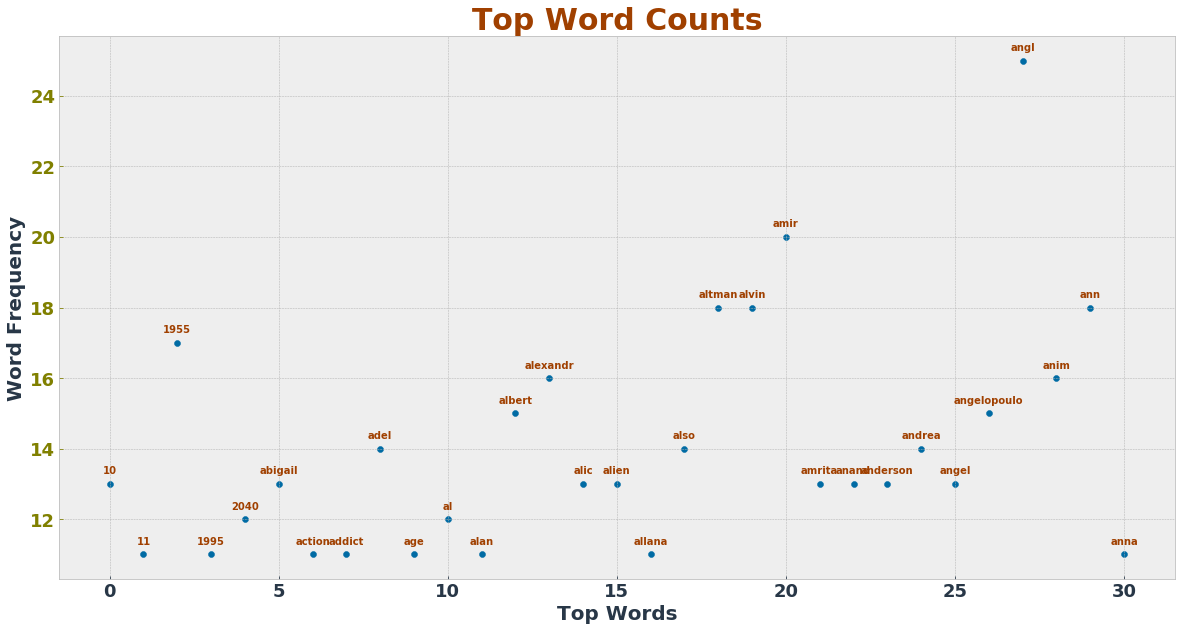

In [58]:
plot_top_words(dt_train_df[label_matrix_train==1],upper_threshold=10000,lower_threshold=10,count=30)

### Task 7: Re-weighing the document term matrix using TF-IDF Scheme

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
tfidf_vectorizer = TfidfVectorizer()

In [61]:
feature_matrix_train = tfidf_vectorizer.fit_transform(review_train_df["review"].tolist())

In [62]:
feature_matrix_train.shape

(40000, 118482)

In [63]:
feature_matrix_valid = tfidf_vectorizer.transform(review_valid_df["review"].tolist())

In [64]:
feature_matrix_valid.shape

(5000, 118482)

In [65]:
feature_matrix_test = tfidf_vectorizer.transform(review_test_df["review"].tolist())

In [66]:
feature_matrix_test.shape

(5000, 118482)

In [67]:
dt_train_df = pd.DataFrame.sparse.from_spmatrix(data = feature_matrix_train, columns = vectorizer.get_feature_names())
dt_valid_df = pd.DataFrame.sparse.from_spmatrix(data = feature_matrix_valid, columns = vectorizer.get_feature_names())
dt_test_df = pd.DataFrame.sparse.from_spmatrix(data = feature_matrix_test, columns = vectorizer.get_feature_names())

### Task 8: Train and Test Machine Learning Models

<p> <h4> Classifer 1:- Naive Bayes </h4> </p>

In [68]:
tic = time.time()
#Train Naive Bayes Model
#More Details: https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import BernoulliNB #Gaussain assume fatures from normal distribution, Bernouli for boolean, multionomial for discreeet
model_nb = BernoulliNB()
model_nb.fit(feature_matrix_train, label_matrix_train)
toc = time.time()
y_pred_nb = model_nb.predict(feature_matrix_valid)
accuracy_train_set = model_nb.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_nb.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("Naive Bayes Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Naive Bayes Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Naive Bayes Model, Accuracy (Train Set) :  0.90355
Naive Bayes Model, Accuracy (Valid Set) :  0.85
Time Taken: 72.74651527404785 ms


<p> <h4> Classifer 2:- Descision Tree </h4> </p>

In [69]:
tic = time.time()
#Train Descision Trees Model
#More Details: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree
from sklearn.tree import DecisionTreeClassifier
maximum_tree_depth= 15
model_dt = DecisionTreeClassifier(max_depth=maximum_tree_depth)
model_dt.fit(feature_matrix_train,label_matrix_train)
toc = time.time()
y_pred_dt = model_nb.predict(feature_matrix_valid)
accuracy_train_set = model_dt.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_dt.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("Descision Tree Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Descision Tree Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Descision Tree Model, Accuracy (Train Set) :  0.81405
Descision Tree Model, Accuracy (Valid Set) :  0.7394
Time Taken: 13988.574743270874 ms


<p> <h4> Classifer 3:- K Nearest Neighbor </h4> </p>

In [70]:
tic = time.time()
#Train K Nearest Negihbor Model
#More Details: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
#MOre Details: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
from sklearn.neighbors import KNeighborsClassifier
number_of_neigbors = 3
minkowski_power = 2 # Manhattan Distance = 1, Euclidean Distance = 2
model_knn = KNeighborsClassifier(n_neighbors=number_of_neigbors, p =minkowski_power)
model_knn.fit(feature_matrix_train,  label_matrix_train)
toc = time.time()
y_pred_knn = model_nb.predict(feature_matrix_valid)
accuracy_train_set = model_knn.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_knn.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("K Nearest Neighbors Model, Accuracy (Train Set) : ", accuracy_train_set)
print("K Nearest Neighbors Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

K Nearest Neighbors Model, Accuracy (Train Set) :  0.88665
K Nearest Neighbors Model, Accuracy (Valid Set) :  0.774
Time Taken: 18.950700759887695 ms


<p> <h4> Classifer 4:- Logistic Regression </h4> </p>

In [71]:
tic = time.time()
#Train Logistic Regression Model
#More Details: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression #import model for logistic regression
l2_norm = 0.4 # regularization parameter
l2_norm_inverse = 1/l2_norm 
maximum_iterations=4000 #maximum number of iterations
model_lr = LogisticRegression(C=l2_norm_inverse,max_iter=maximum_iterations) #create logistic regression model
model_lr.fit(feature_matrix_train,  label_matrix_train)
toc = time.time()
y_pred_lr = model_nb.predict(feature_matrix_valid)
accuracy_train_set = model_lr.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_lr.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("Logistic Regression Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Logistic Regression Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Logistic Regression Model, Accuracy (Train Set) :  0.9479
Logistic Regression Model, Accuracy (Valid Set) :  0.898
Time Taken: 4084.7015380859375 ms


<p> <h4> Classifer 5:- Support Vector Machine </h4> </p>

In [72]:
tic = time.time()
#Train Support Vector Machine Model
#More Details: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
from sklearn.svm import LinearSVC
l2_norm = 2.1
l2_norm_inverse = 1/l2_norm
maximum_iterations=4000 #maximum number of iterations
model_svm = LinearSVC(C=l2_norm_inverse,max_iter=maximum_iterations) #create support vector machine model
model_svm.fit(feature_matrix_train,  label_matrix_train)
toc = time.time()
y_pred_svm = model_nb.predict(feature_matrix_valid)
accuracy_train_set = model_svm.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_svm.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("Support Vector Machine Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Support Vector Machine Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Support Vector Machine Model, Accuracy (Train Set) :  0.9676
Support Vector Machine Model, Accuracy (Valid Set) :  0.8996
Time Taken: 478.5897731781006 ms


<p> <h4> Classifer 6:- Bagging Classifier (Base Estimator = LinearSVC) </h4> </p>

In [73]:
tic = time.time()
#Train a MLP classifier
# Details:https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifierfrom sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
l2_norm = 2
l2_norm_inverse = 1/l2_norm
maximum_iterations=4000 #maximum number of iterations
 
model_bc = BaggingClassifier(base_estimator=LinearSVC(C=l2_norm_inverse,max_iter=maximum_iterations),
                             n_estimators=30, 
                             random_state=0)

model_bc.fit(feature_matrix_train,  label_matrix_train)
toc = time.time()
y_pred_stacked = model_bc.predict(feature_matrix_valid)
accuracy_train_set = model_bc.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_bc.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("Bagging Classifier ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Bagging Classifier ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Bagging Classifier ML Model, Accuracy (Train Set) :  0.966075
Bagging Classifier ML Model, Accuracy (Valid Set) :  0.8992
Time Taken: 12434.33427810669 ms


<p> 
<h4>
    Classifer 7:- Stacked ML CLassifer (Naive Bayes, K Nearest Neighbor, Support Vector Machine)
</h4>
</p>

In [74]:
tic = time.time()
#Create a stack of these estimators
estimators = [
    ("nb",model_nb), #stack naive bayes
    ("knn",model_knn), #stack K nearest neighor
    ('svm', model_svm) #stack support vector machine
]

#Train a stacked model
# Details: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
from sklearn.ensemble import StackingClassifier
model_stacked = StackingClassifier(estimators=estimators, final_estimator=model_lr) #use logisitc regression as the final estimator
model_stacked.fit(feature_matrix_train,  label_matrix_train)
toc = time.time()
y_pred_stacked = model_nb.predict(feature_matrix_valid)
accuracy_train_set = model_stacked.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_stacked.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("Stacked ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Stacked ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Stacked ML Model, Accuracy (Train Set) :  0.97165
Stacked ML Model, Accuracy (Valid Set) :  0.906
Time Taken: 71742.77710914612 ms


<p> 
<h4>
    Classifer 8:- Random Forests (Base Estimator = Descision Tree)
</h4>
</p>

In [75]:
tic = time.time()
#Train a Random Forest model
# Details: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
estimators = 100
forest_depth = 25
model_rf = RandomForestClassifier(n_estimators=estimators, #The number of trees in the forest
                                  max_depth = forest_depth) #The maximum depth of the tree.
model_rf.fit(feature_matrix_train,  label_matrix_train)
toc = time.time()
y_pred_stacked = model_rf.predict(feature_matrix_valid)
accuracy_train_set = model_rf.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_rf.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("Random Forests ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Random Forests ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Random Forests ML Model, Accuracy (Train Set) :  0.935125
Random Forests ML Model, Accuracy (Valid Set) :  0.8438
Time Taken: 10960.322380065918 ms


<p> 
<h4>
    Classifer 9:- AdaBoostClassifier (Base Estimator = Descision Tree)
</h4>

</p>

In [76]:
tic = time.time()
#Train a Random Forest model
# Details: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import AdaBoostClassifier
estimators = 100
model_abc = AdaBoostClassifier(n_estimators=estimators) #The number of trees in the forest
model_abc.fit(feature_matrix_train,  label_matrix_train)
toc = time.time()
y_pred_stacked = model_abc.predict(feature_matrix_valid)
accuracy_train_set = model_abc.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_abc.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("Ada Boost CLassifier ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Ada Boost CLassifier ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Ada Boost CLassifier ML Model, Accuracy (Train Set) :  0.837175
Ada Boost CLassifier ML Model, Accuracy (Valid Set) :  0.828
Time Taken: 49544.52419281006 ms


<p> 
<h4>
    Classifer 10:-ExtraTreesClassifier (Base Estimator = Descision Tree)
</h4>
</p>

In [77]:
tic = time.time()
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
estimators = 200
depth = 25
model_etc = ExtraTreesClassifier(n_estimators = estimators, max_depth = depth)
model_etc.fit(feature_matrix_train,  label_matrix_train)
toc = time.time()
y_pred_stacked = model_etc.predict(feature_matrix_valid)
accuracy_train_set = model_etc.score(feature_matrix_train, label_matrix_train)  #get accuracy on train set
accuracy_valid_set = model_etc.score(feature_matrix_valid, label_matrix_valid)  #get accuracy on valid set
print("Extra Trees Classifer ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Extra Trees Classifer ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Extra Trees Classifer ML Model, Accuracy (Train Set) :  0.95235
Extra Trees Classifer ML Model, Accuracy (Valid Set) :  0.8414
Time Taken: 10397.042512893677 ms


### Task 9: Plot Evaluation Metrics for Machine Learning Models

In [78]:
from sklearn.model_selection import train_test_split #split data into train,test sets
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve,  plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from matplotlib import pyplot as plt

In [79]:
#make a list of classifers
ml_models_list = [model_nb, #Naive Bayes
                  model_dt, #Descision Trees
                 model_knn, #K nearest neighbors
                 model_lr, #Logistic Regression
                 model_svm, #Support Vector Machine
                  model_bc, #bagging classifer (base: descision tree)
                 model_stacked, #Stacked Model: NB, SVM, KNN, LR
                  model_rf, #random forestws
                  model_abc, #adaboost classifier
                  model_etc #extra trees classifier
                 ]

In [104]:
models = []
accuracies = []
precisions = []
recalls = []
roc_scores = []
from sklearn.metrics import roc_auc_score
tic = time.time()
for model in ml_models_list:
    accuracy = model.score(feature_matrix_test, label_matrix_test)  #get accuracy
    y_pred = model.predict(feature_matrix_test) #get predictions
    model_name = type(model).__name__
    print("Accuracy("+ model_name + "): ", accuracy.round(4)) #display accuracy
    print("Precision("+ model_name + "): ", precision_score(label_matrix_test,y_pred).round(4)) #display precision
    print("Recall("+ model_name + "): ",recall_score(label_matrix_test,y_pred).round(4)) #display recall
    print("ROC Score("+ model_name + "): ",roc_auc_score(label_matrix_test,y_pred).round(4)) #display recall
    
    print("\n")
    models.append(model_name)
    accuracies.append(accuracy.round(4))
    precisions.append(precision_score(label_matrix_test,y_pred).round(4))
    recalls.append(recall_score(label_matrix_test,y_pred).round(4))
    roc_scores.append(roc_auc_score(label_matrix_test,y_pred).round(4))
toc = time.time()
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Accuracy(BernoulliNB):  0.851
Precision(BernoulliNB):  0.8594
Recall(BernoulliNB):  0.8316
ROC Score(BernoulliNB):  0.8506


Accuracy(DecisionTreeClassifier):  0.7282
Precision(DecisionTreeClassifier):  0.6838
Recall(DecisionTreeClassifier):  0.8271
ROC Score(DecisionTreeClassifier):  0.7303


Accuracy(KNeighborsClassifier):  0.7696
Precision(KNeighborsClassifier):  0.7281
Recall(KNeighborsClassifier):  0.8447
ROC Score(KNeighborsClassifier):  0.7712


Accuracy(LogisticRegression):  0.8876
Precision(LogisticRegression):  0.8756
Recall(LogisticRegression):  0.8978
ROC Score(LogisticRegression):  0.8878


Accuracy(LinearSVC):  0.8884
Precision(LinearSVC):  0.8764
Recall(LinearSVC):  0.8987
ROC Score(LinearSVC):  0.8886


Accuracy(BaggingClassifier):  0.8902
Precision(BaggingClassifier):  0.8793
Recall(BaggingClassifier):  0.8991
ROC Score(BaggingClassifier):  0.8904


Accuracy(StackingClassifier):  0.8988
Precision(StackingClassifier):  0.8871
Recall(StackingClassifier):  0.9089
ROC Scor

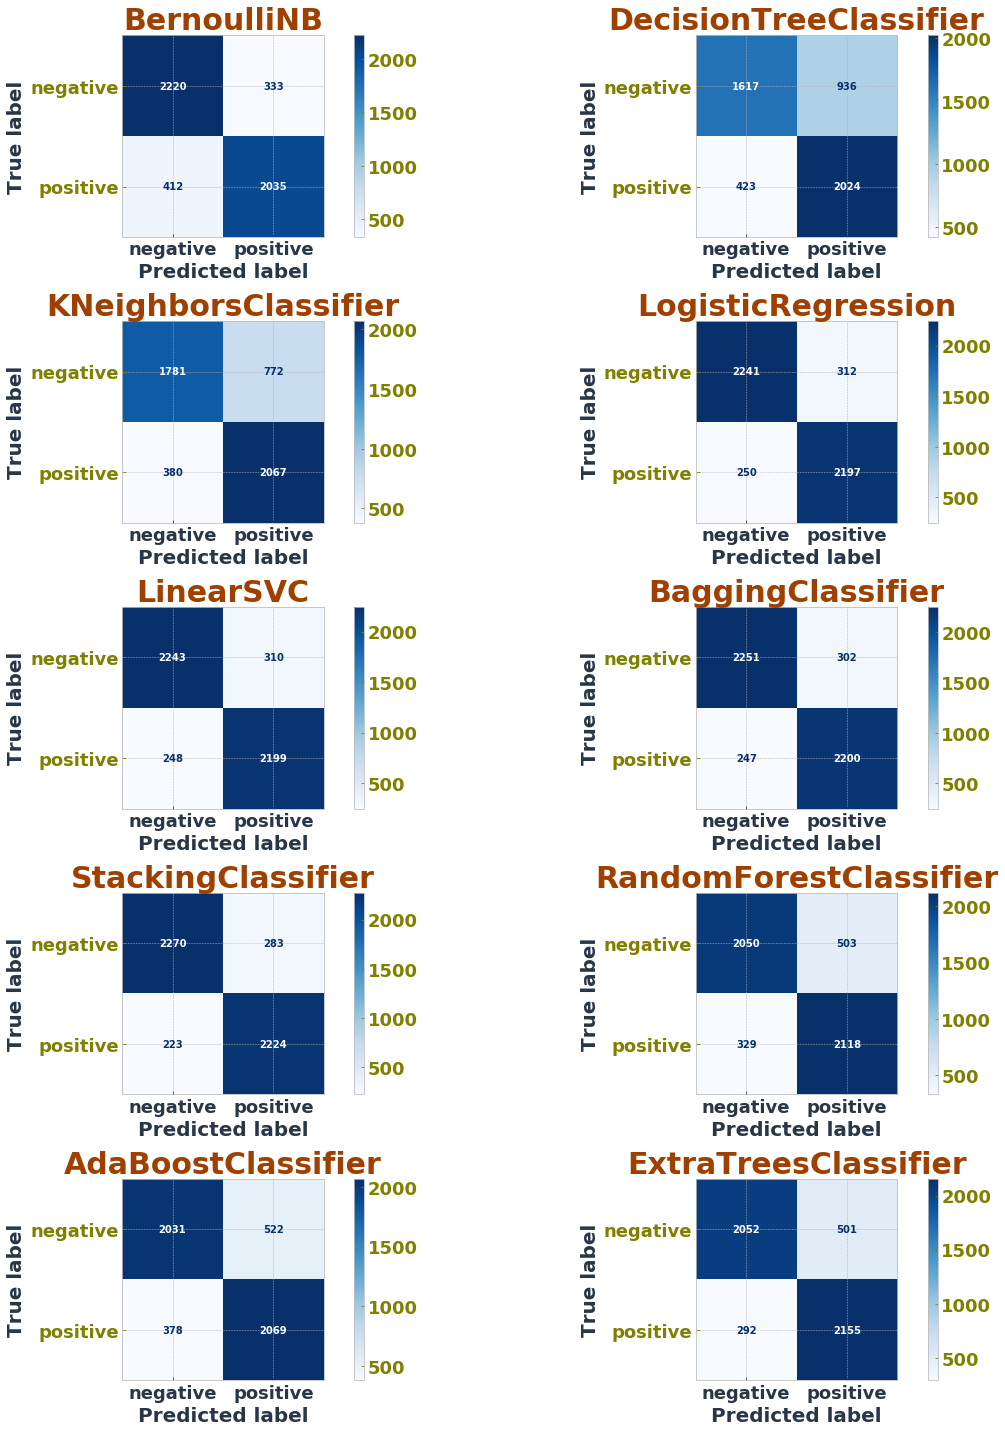

Time Taken: 23377.083778381348 ms


In [84]:
tic = time.time()
#Plot Confusion Matrix For all Models
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(17,20))

for model,ax in zip(ml_models_list, axes.flatten()):
    
    plot_confusion_matrix(model, 
                          feature_matrix_test, 
                          label_matrix_test, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=["negative","positive"])
    
    ax.title.set_text(type(model).__name__)
plt.tight_layout()  
plt.show()
toc = time.time()
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

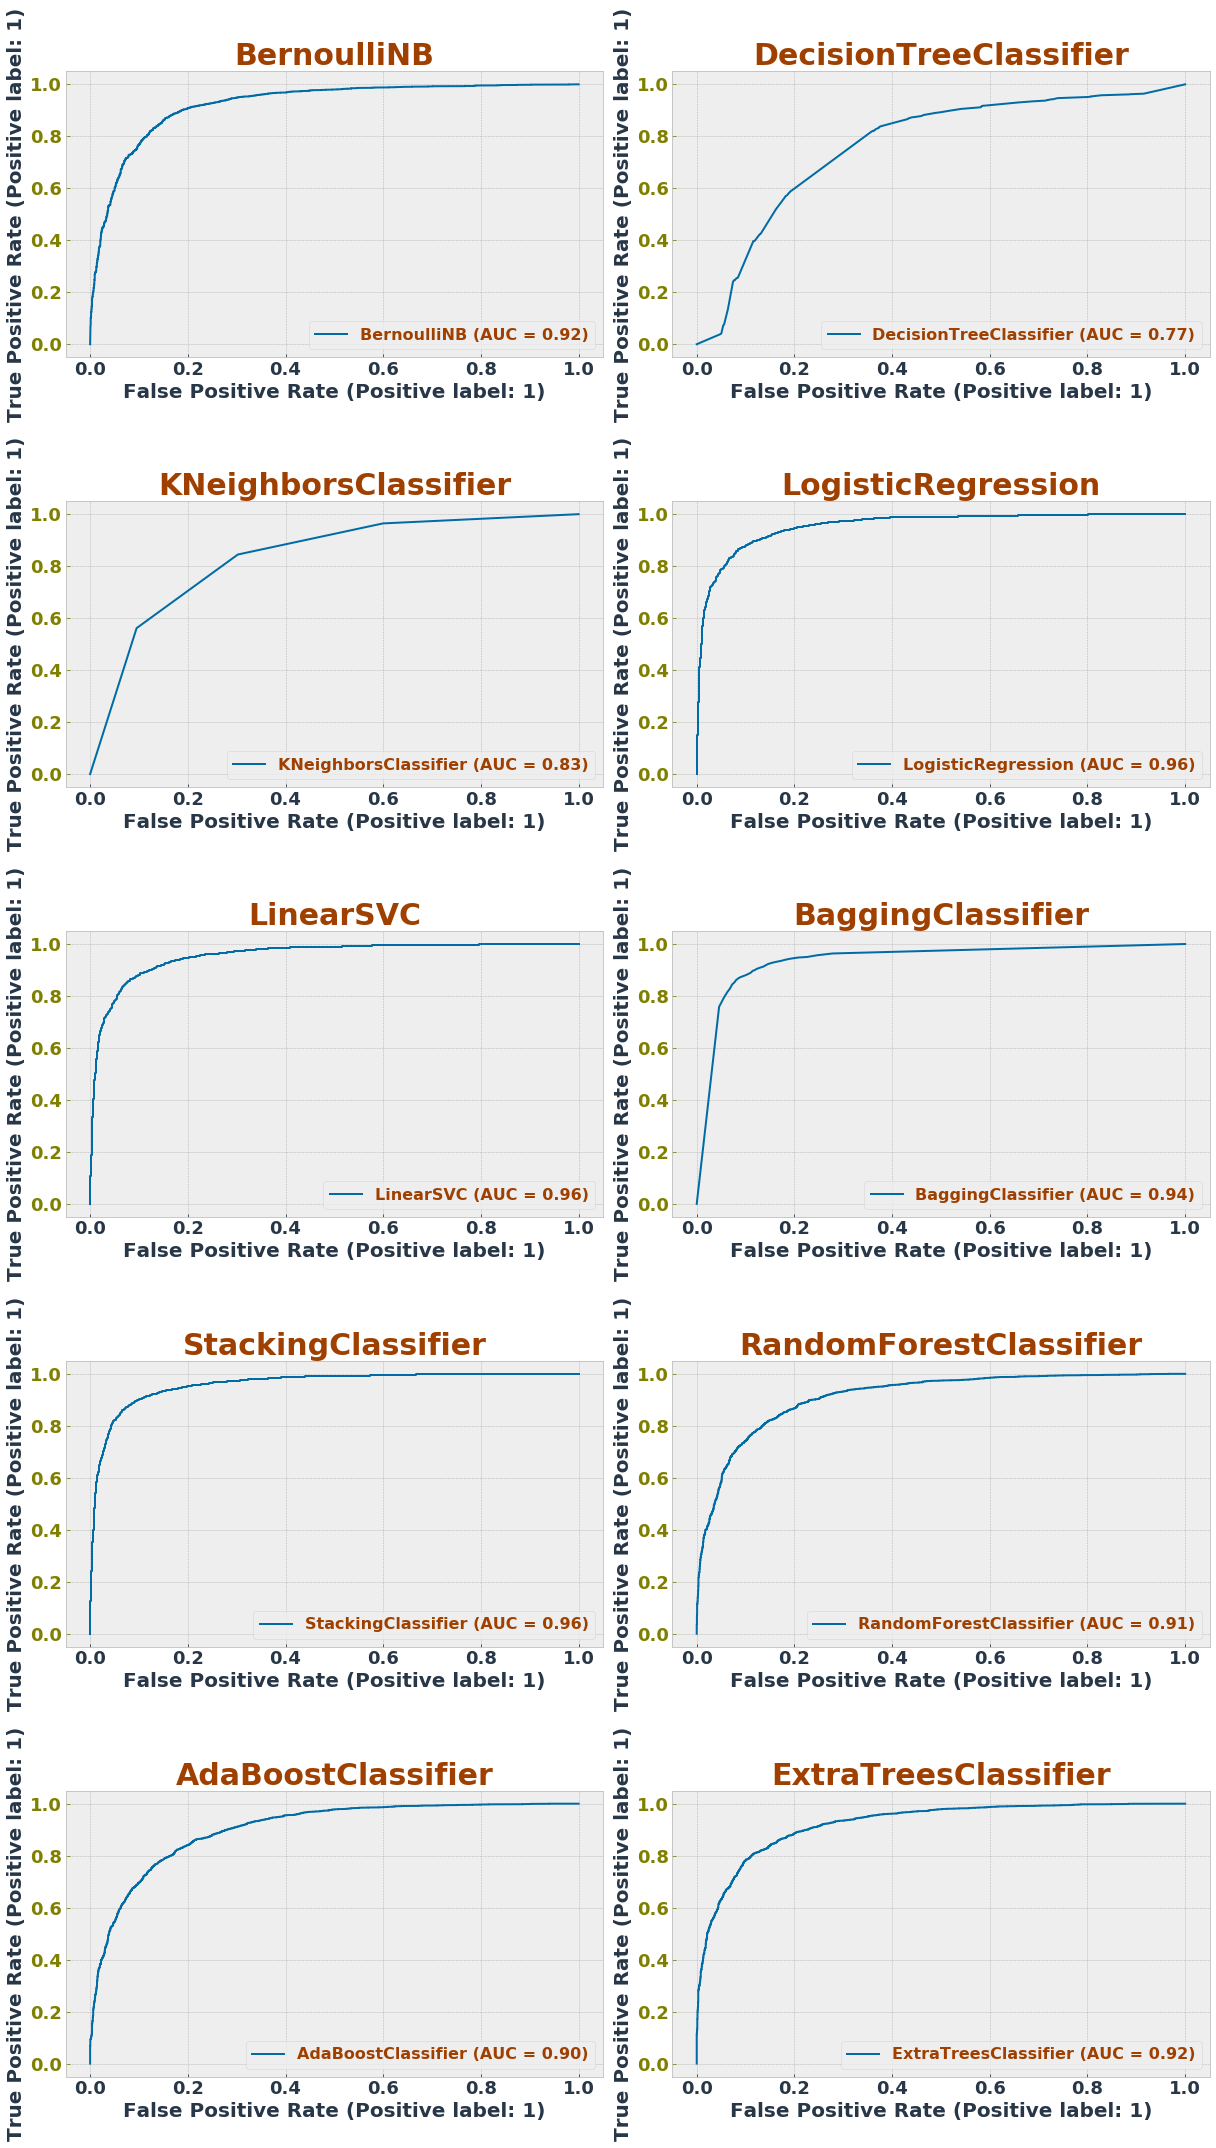

Time Taken: 23303.836584091187 ms


In [87]:
tic = time.time()
#Plot ROC Curve For all Models
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(17,30))

for model, ax in zip(ml_models_list,axes.flatten()):
    
    plot_roc_curve(model,feature_matrix_test,label_matrix_test,ax=ax)
    
    ax.title.set_text(type(model).__name__)

plt.tight_layout()  
plt.show()
toc = time.time()
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

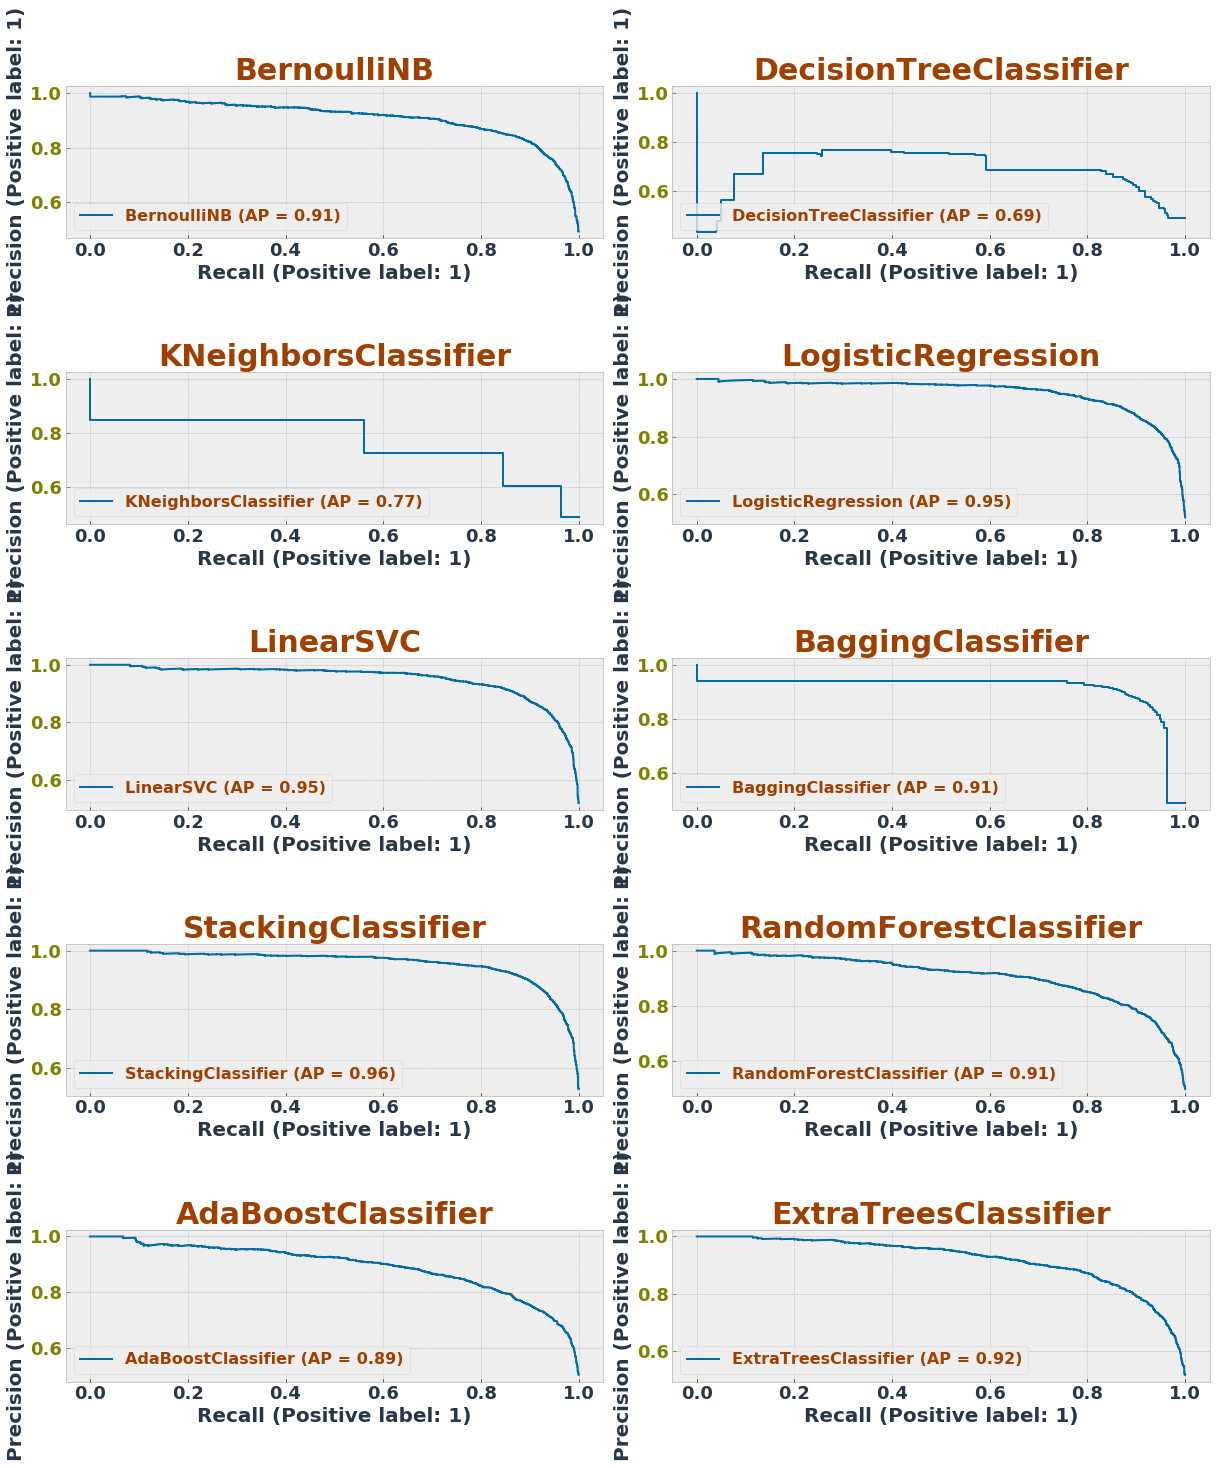

Time Taken: 23260.940074920654 ms


In [86]:
tic = time.time()
#Plot Precision Recall CUrve FOr ALl Models
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(17,20))

for model, ax in zip(ml_models_list,axes.flatten()):
    
    plot_precision_recall_curve(model,feature_matrix_test,label_matrix_test,ax=ax)
    
    ax.title.set_text(type(model).__name__)

plt.tight_layout()  
plt.show()
toc = time.time()
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

### Task 10: Summarize Performace of Machine Learning Models

In [107]:
results = pd.DataFrame({"Model" : models, "Accuracy" : accuracies, "Precision" : precisions, "Recall" : recalls, 'ROC Score' :roc_scores})
results

,Model,Accuracy,Precision,Recall,ROC Score
0,BernoulliNB,0.85,0.86,0.83,0.85
1,DecisionTreeClassifier,0.73,0.68,0.83,0.73
2,KNeighborsClassifier,0.77,0.73,0.84,0.77
3,LogisticRegression,0.89,0.88,0.90,0.89
4,LinearSVC,0.89,0.88,0.90,0.89
5,BaggingClassifier,0.89,0.88,0.90,0.89
6,StackingClassifier,0.90,0.89,0.91,0.90
7,RandomForestClassifier,0.83,0.81,0.87,0.83
8,AdaBoostClassifier,0.82,0.80,0.85,0.82
9,ExtraTreesClassifier,0.84,0.81,0.88,0.84


In [108]:
results.set_index('Model', inplace=True)
results

,Accuracy,Precision,Recall,ROC Score
Model,,,,
BernoulliNB,0.85,0.86,0.83,0.85
DecisionTreeClassifier,0.73,0.68,0.83,0.73
KNeighborsClassifier,0.77,0.73,0.84,0.77
LogisticRegression,0.89,0.88,0.90,0.89
LinearSVC,0.89,0.88,0.90,0.89
BaggingClassifier,0.89,0.88,0.90,0.89
StackingClassifier,0.90,0.89,0.91,0.90
RandomForestClassifier,0.83,0.81,0.87,0.83
AdaBoostClassifier,0.82,0.80,0.85,0.82


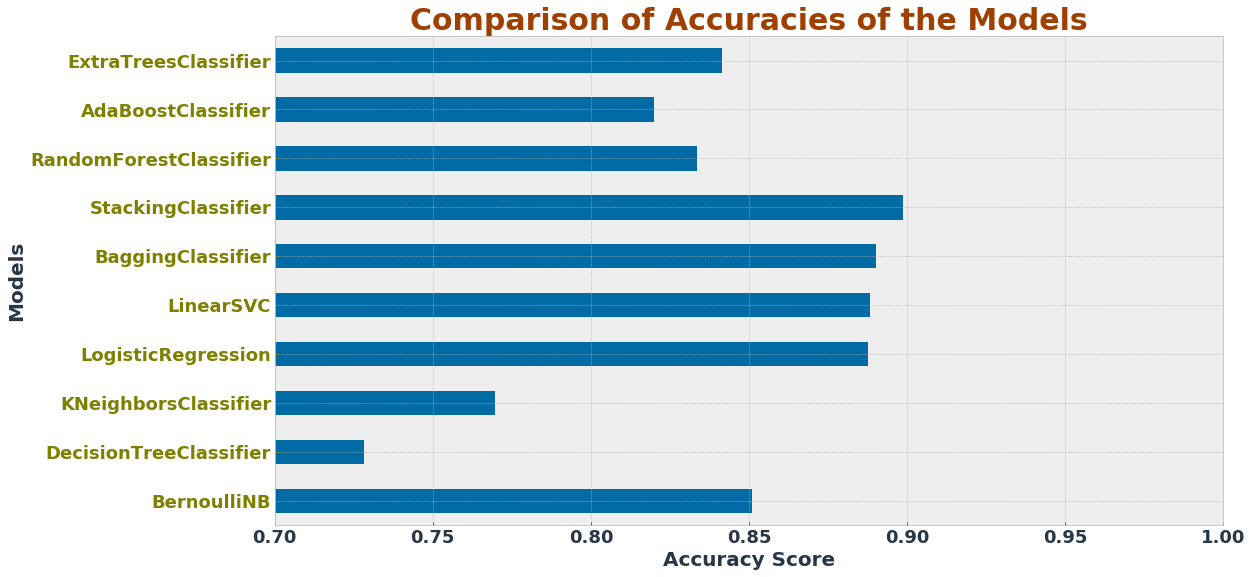

In [116]:
plt.figure(figsize = (17,9))
results["Accuracy"].plot(kind = 'barh')
plt.title("Comparison of Accuracies of the Models")
plt.ylabel("Models")
plt.xlim(0.70, 1.0)
plt.xlabel("Accuracy Score")
plt.show();

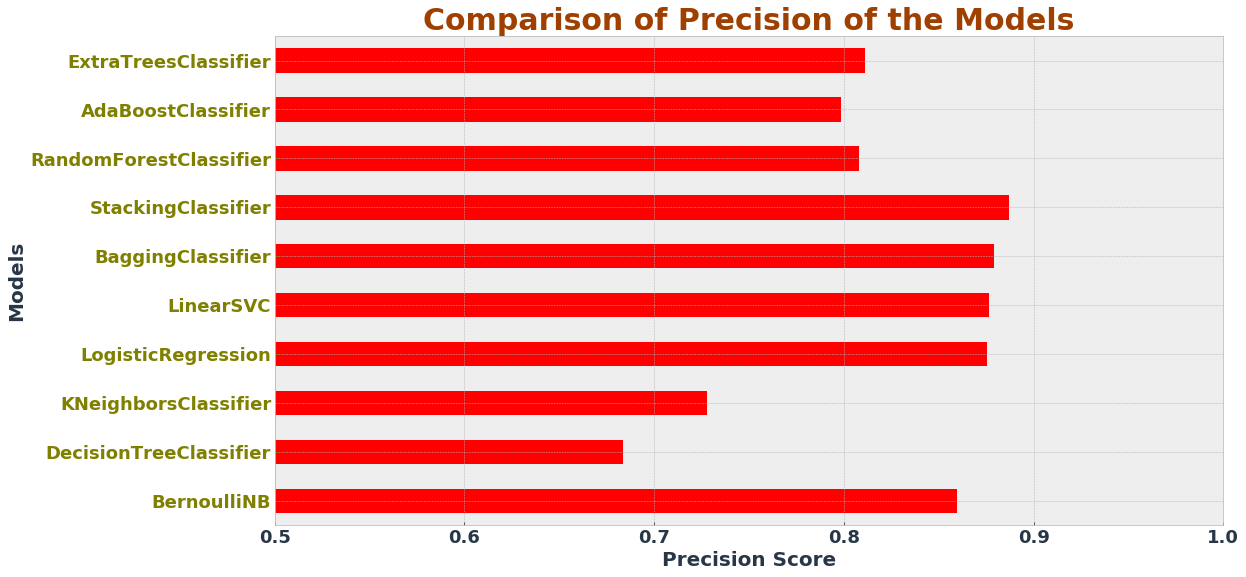

In [124]:
plt.figure(figsize = (17,9))
results["Precision"].plot(kind = 'barh', color = 'red')
plt.title("Comparison of Precision of the Models")
plt.ylabel("Models")
plt.xlim(0.50, 1.0)
plt.xlabel("Precision Score")
plt.show();

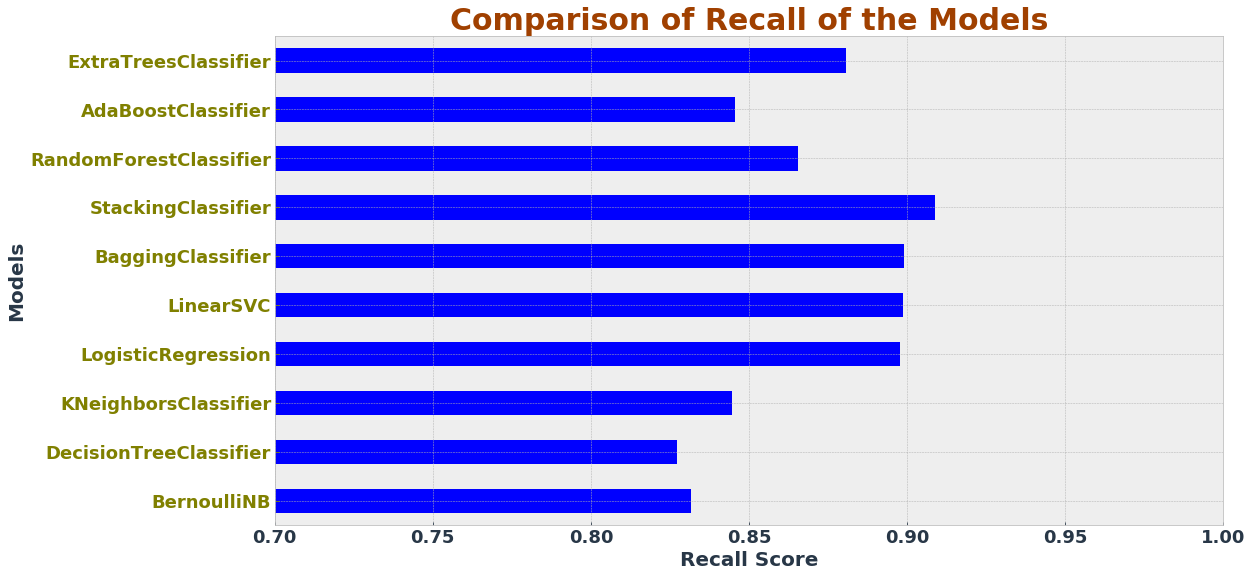

In [120]:
plt.figure(figsize = (17,9))
results["Recall"].plot(kind = 'barh', color = 'blue')
plt.title("Comparison of Recall of the Models")
plt.ylabel("Models")
plt.xlim(0.70, 1.0)
plt.xlabel("Recall Score")
plt.show();

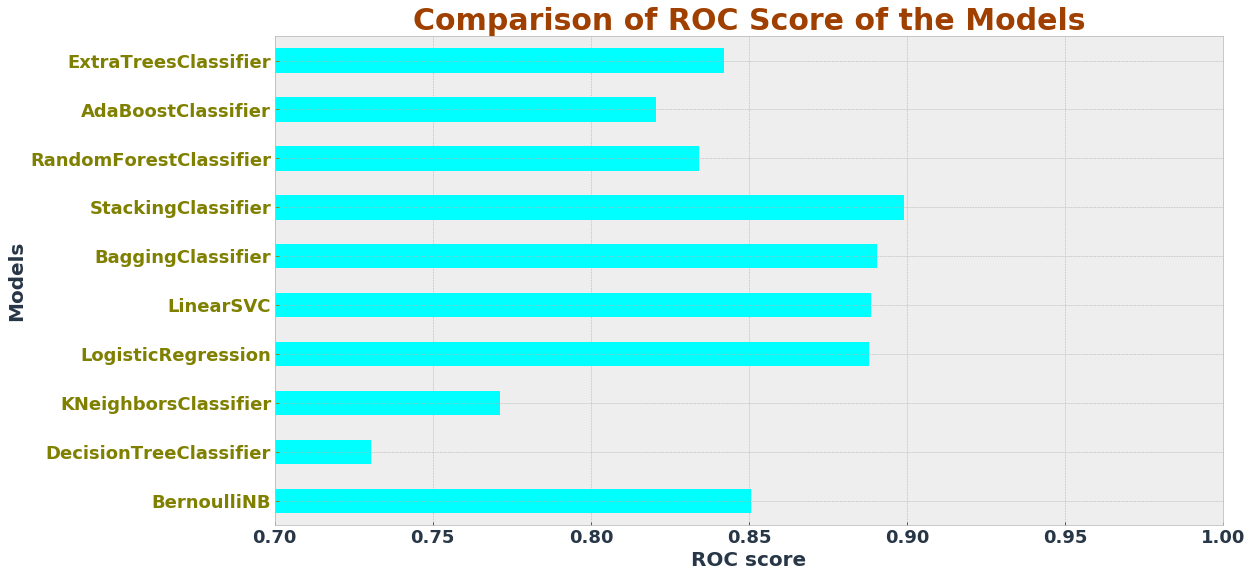

In [121]:
plt.figure(figsize = (17,9))
results["ROC Score"].plot(kind = 'barh', color = 'cyan')
plt.title("Comparison of ROC Score of the Models")
plt.ylabel("Models")
plt.xlim(0.70, 1.0)
plt.xlabel("ROC score")
plt.show();

<Figure size 1224x648 with 0 Axes>

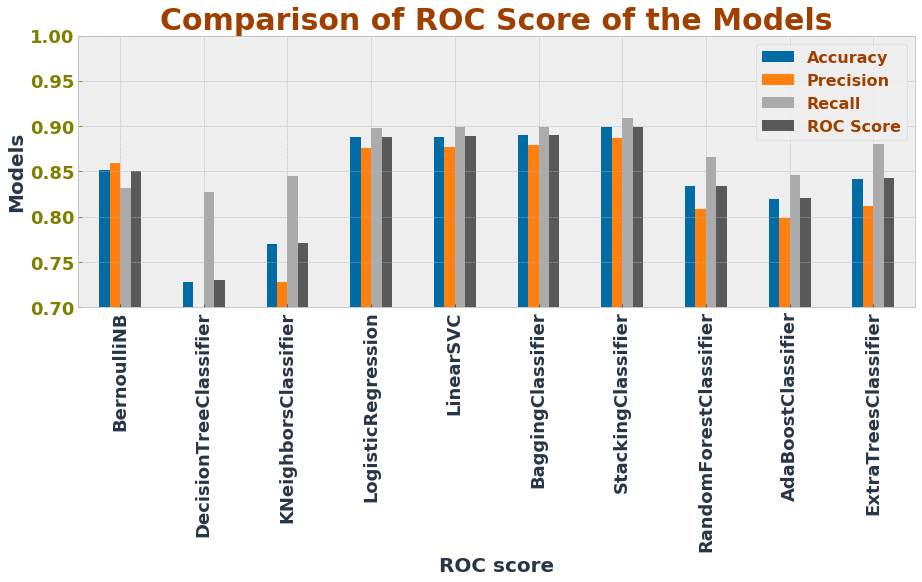

In [128]:
plt.figure(figsize = (17,9))
results.plot(kind = 'bar')
plt.title("Comparison of ROC Score of the Models")
plt.ylabel("Models")
plt.ylim(0.70, 1.0)
plt.xlabel("ROC score")
plt.show();

### Task 11: Movie Rating Generator

In [89]:
from textblob import TextBlob

def generate_rating(ml_models,movie_review,preprocessed=False):
    
    processed_text = ""
    
    if not preprocessed:
        #pre process review
        processed_text = [process_string(movie_review)]

        print("PreProcessed Review: ")
        print(processed_text)
        print("")
        #make sure the text in string
        #processed_text = [str(processed_text)]
    else:
        processed_text = [movie_review]
    
    #generate feature matrix for the review using TF-IDF Scheme
    feature_matrix = tfidf_vectorizer.transform(processed_text)
    
    #container to store predictions
    predictions = []
    model_names = []
    
    #get predictions from all 10 classifiers
    for model in ml_models:
        
        #get model name
        model_names.append(model.__class__.__name__)
        
        #get prediction from
        predictions.append(model.predict(feature_matrix))

    
    print("Predictions By Classifiers: \n")
    for model, prediction in zip(model_names,predictions):
        print(model,":", prediction)
    
    #convert predictions from llist to numpy array
    predictions = np.array(predictions)
    
    #sum predictions from all models to get rating
    rating = np.sum(predictions)
    
    print("")
    print("Movie Rating(0-10): " + str(rating))
    
    print("")
    
    try:
        #The polarity score is a float within the range [-1.0, 1.0].
        pol =  TextBlob(movie_review).sentiment.polarity
    except:
        pol = -999999
        
    print("TextBlob Sentiment Polarity(UnPreprocessed): " + str(pol))

In [90]:
review_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 11841 to 23333
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [91]:
r_num = 50
review_test_df.iloc[r_num]
#web: https://www.imdb.com/title/tt1635327/reviews?ref_=tt_urv

review       note saw approxim last half movi feel free tak...
sentiment                                             negative
Name: 1984, dtype: object

In [92]:
custom_review = "I dont know how i feel about this movie. Guess i dont care https://www.imdb.com/title/tt1635327/reviews?ref_=tt_urv"
custom_review

'I dont know how i feel about this movie. Guess i dont care https://www.imdb.com/title/tt1635327/reviews?ref_=tt_urv'

In [93]:
generate_rating(ml_models_list,custom_review)

PreProcessed Review: 
['dont know feel movi guess dont care']

Predictions By Classifiers: 

BernoulliNB : [0]
DecisionTreeClassifier : [1]
KNeighborsClassifier : [0]
LogisticRegression : [0]
LinearSVC : [0]
BaggingClassifier : [0]
StackingClassifier : [0]
RandomForestClassifier : [1]
AdaBoostClassifier : [1]
ExtraTreesClassifier : [1]

Movie Rating(0-10): 4

TextBlob Sentiment Polarity(UnPreprocessed): 0.0


In [94]:
custom_review = "I dont know how i feel about this movie. www.google.com www.imdb.com Guess i dont care "
custom_review

'I dont know how i feel about this movie. www.google.com www.imdb.com Guess i dont care '

In [95]:
generate_rating(ml_models_list,custom_review)

PreProcessed Review: 
['dont know feel movi guess dont care']

Predictions By Classifiers: 

BernoulliNB : [0]
DecisionTreeClassifier : [1]
KNeighborsClassifier : [0]
LogisticRegression : [0]
LinearSVC : [0]
BaggingClassifier : [0]
StackingClassifier : [0]
RandomForestClassifier : [1]
AdaBoostClassifier : [1]
ExtraTreesClassifier : [1]

Movie Rating(0-10): 4

TextBlob Sentiment Polarity(UnPreprocessed): 0.0


In [96]:
custom_review = """I have honestly never felt so confused after watching a film, a lot of people saying watch it twice but I couldn't put myself through that again. The idea is good.. but they have made it far too complicated, a bit pretentious and unfortunately no real heart to any of the characters. Disappointed."""
custom_review

"I have honestly never felt so confused after watching a film, a lot of people saying watch it twice but I couldn't put myself through that again. The idea is good.. but they have made it far too complicated, a bit pretentious and unfortunately no real heart to any of the characters. Disappointed."

In [97]:
generate_rating(ml_models_list,custom_review)

PreProcessed Review: 
['honestli never felt confus watch film lot peopl say watch twice put idea good made far complic bit pretenti unfortun real heart charact disappoint']

Predictions By Classifiers: 

BernoulliNB : [0]
DecisionTreeClassifier : [1]
KNeighborsClassifier : [0]
LogisticRegression : [0]
LinearSVC : [0]
BaggingClassifier : [0]
StackingClassifier : [0]
RandomForestClassifier : [0]
AdaBoostClassifier : [1]
ExtraTreesClassifier : [0]

Movie Rating(0-10): 2

TextBlob Sentiment Polarity(UnPreprocessed): -0.19374999999999998
